# Session 2 Part 1: Going Further, Discovering class-imbalance in datasets

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

Since we have done the most basic training example, got our hands on skorch and on the dataset, we are going to repeat our process using a more realistic use case. This time, our dataset will be severely unbalanced (10% of all data will be images of aircrafts), like in real life (or not even like in real life but it's getting closer).

Here, we won't guide you, you will have to use what you learned in the previous notebooks as well as what you learned in previous data science class to try to devise a way to train a good model

You are going to:
- Do a first "naive" run with the full data
- Diagnose performance
- Try to improve it by tuning several factors:
  - The dataset itself
  - The optimization parameters
  - The network architecture

**Remember that "deep learning" is still considered somewhat a black art so it's hard to know in advance what will work.**


In [1]:
# Put your imports here
import numpy as np

import random
import time

import cv2
from matplotlib import pyplot as plt
from torch import nn
import torchvision
from torchvision import transforms

/home/charles-alexis/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Global variables
TRAINVAL_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/large_aircraft_dataset.npz"

## Q0 Downloading & splitting the dataset

You will get the following:

- 50k images in training which you should use as training & validation
- 5k images in test, which you should only use to compute your final metrics on. **Don't ever use this dataset for early stopping / intermediary metrics**

<img src="https://i.stack.imgur.com/pXAfX.png" alt="pokemon" style="width: 400px;"/>

In [ ]:
# Download the dataset
ds = np.DataSource("/tmp/")
f = ds.open(TRAINVAL_DATASET_URL, "rb")
trainval_dataset = np.load(f)
trainval_images = trainval_dataset["train_images"]
trainval_labels = trainval_dataset["train_labels"]
test_images = trainval_dataset["test_images"]
test_labels = trainval_dataset["test_labels"]

In [ ]:
print(trainval_images.shape)
print(np.unique(trainval_labels, return_counts=True))

print(test_images.shape)
print(np.unique(test_labels, return_counts=True))

### a. Data Exploration

a. Can you plot some images ?

b. What is the aircraft/background ratio ?

In [ ]:
plt.imshow(trainval_images[random.randint(0,trainval_images.shape[0]),:,:,:])

### b. Dataset Splitting

Here we will split the trainval_dataset to obtain a training and a validation dataset.

For example, try to use 20% of the images as validation

You must have seen that the dataset was really unbalanced, so a random sampling will not work...

Use stratified sampling to keep the label distribution between training and validation

In [ ]:
background_indexes = np.where(trainval_labels == 0)[0]
foreground_indexes = np.where(trainval_labels == 1)[0]

train_bg_indexes = background_indexes[: int(0.8 * len(background_indexes))]
valid_bg_indexes = background_indexes[int(0.8 * len(background_indexes)) :]

train_fg_indexes = foreground_indexes[: int(0.8 * len(foreground_indexes))]
valid_fg_indexes = foreground_indexes[int(0.8 * len(foreground_indexes)) :]

train_indexes = list(train_bg_indexes) + list(train_fg_indexes)
valid_indexes = list(valid_bg_indexes) + list(valid_fg_indexes)

train_images = trainval_images[train_indexes, :, :, :]
train_labels = trainval_labels[train_indexes]

valid_images = trainval_images[valid_indexes, :, :, :]
valid_labels = trainval_labels[valid_indexes]

In [7]:
print(np.unique(train_labels, return_counts=True))

(array([0, 1]), array([33120,  3680]))


In [8]:
print(np.unique(valid_labels, return_counts=True))

(array([0, 1]), array([8280,  920]))


In [9]:
# Compute the dataset statistics in [0.,1.], we're going to use it to normalize our data

mean = np.mean(train_images, axis=(0, 1, 2)) / 255.0
std = np.std(train_images, axis=(0, 1, 2)) / 255.0

mean, std

(array([0.27568185, 0.28949009, 0.26529746]),
 array([0.16389538, 0.16174321, 0.15423233]))

## Q1. Training & metrics

During Session 1, you learnt how to set up your environment on Colab, train a basic CNN on a small training set and plot metrics. Now let's do it again !

### First run

Once you have downloaded & created your training & validation dataset, use the notebook from Session 1 to get:

a. Training of the model using steps seen during Session 1

b. Compute and plot metrics (confusion matrix, ROC curve) based on this training

c. Compare the metrics between this new dataset and the one from Session 1

d. What did you expect ? Is your model working well ?

In [10]:
from typing import Callable

import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_per_process_memory_fraction(0.7)
# DEVICE = torch.device("cpu")

In [12]:
# Helper functions to get you started
class NpArrayDataset(Dataset):
    def __init__(
        self,
        images: np.ndarray,
        labels: np.ndarray,
        image_transforms: Callable = None,
        label_transforms: Callable = None,
    ):
        self.images = images
        self.labels = labels
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index: int):
        x = self.images[index]
        y = self.labels[index]

        if self.image_transforms is not None:
            x = self.image_transforms(x)
        else:
            x = torch.tensor(x)

        if self.label_transforms is not None:
            y = self.label_transforms(y)
        else:
            y = torch.tensor(y)

        return x, y

In [13]:
# Data loading
image_transforms = transforms.Compose(
    [
        # Add data augmentation ?
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

target_transforms = None

# load the training data
train_set = NpArrayDataset(
    images=train_images,
    labels=train_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

# load the validation data
validation_set = NpArrayDataset(
    images=valid_images,
    labels=valid_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)
val_loader = DataLoader(validation_set, batch_size=64, shuffle=True)

define your model, fill the blanks

Be careful, this time we are zero padding images so convolutions do not reduce image size !

![padding](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

In [14]:
def _init_weights(model):
    for m in model.modules():
        # Initialize all convs
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")


def model_fn():

    model = nn.Sequential(
        # size: 3 x 64 x 64
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        # size: 32 x 64 x 64
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # size: 32 x 32 x 32
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        # size: 64 x 32 x 32
        nn.MaxPool2d(2),
        # size: 64 x ? x ?
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # size: ? x ? x ?
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        # size: ? x ? x ?
        nn.Flatten(),
        nn.Linear(in_features=4*4*128, out_features=256),
        nn.ReLU(),
        nn.Dropout(p=0.10),
        nn.Linear(in_features=256, out_features=1),
        nn.Sigmoid(),
    )

    _init_weights(model)

    return model

model = model_fn()

model.to(DEVICE)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): MaxPool2d(kernel_size=2

In [15]:
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): MaxPool2d(kernel_size=2

In [16]:
# declare optimizers and loss
criterion = nn.BCELoss(reduction="mean")
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9) #test avec adam

In [17]:
def train_one_epoch(model, train_loader):

    epoch_loss = []

    for i, batch in enumerate(train_loader):

        # get one batch
        x, y_true = batch
        x = x.to(DEVICE)
        y_true = y_true.to(DEVICE)

        # format the y_true so that it is compatible with the loss
        y_true = y_true.view((-1, 1)).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        y_pred = model(x)

        # compute loss
        loss = criterion(y_pred, y_true)

        # backward
        loss.backward()

        # update parameters
        optimizer.step()

        # save statistics
        epoch_loss.append(loss.item())

        if i % 100 == 0:
            print(f"Batch {i}, curr loss = {loss.item():.03f}")

    return np.asarray(epoch_loss).mean()


def valid_one_epoch(model, valid_loader):

    epoch_loss = []
    epoch_accuracy = []

    for i, batch in enumerate(valid_loader):
        with torch.no_grad():
            # get one batch
            x, y_true = batch
            x = x.to(DEVICE)
            y_true = y_true.to(DEVICE)

            # format the y_true so that it is compatible with the loss
            y_true = y_true.view((-1, 1)).float()

            # forward
            y_pred = model(x)

            # compute loss and accuracy
            loss = criterion(y_pred, y_true)
            threshold = 0.05
            accuracy = y_true[y_pred>threshold].sum()-(y_true-1)[y_pred<threshold].sum()
            accuracy = accuracy/y_true.size(dim=0)

            # save statistics
            epoch_loss.append(loss.item())
            epoch_accuracy.append(accuracy.item())

    return np.asarray(epoch_loss).mean(), np.asarray(epoch_accuracy).mean()

In [18]:
# Run your training and plot your train/val metrics
# You can copy paste the functions and your loops that gives the best results

model = model_fn()

# moving model to gpu if available
model = model.to(DEVICE)

print(model)

EPOCHS = 20  # Set number of epochs, example 100
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

criterion = nn.BCELoss(reduction="mean")
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM,weight_decay=1e-4)

# Send model to GPU
model = model.to(DEVICE)

train_losses = []
valid_losses = []
valid_accuracy = []
early_stop = 5 # 0 to deactivate
count = 0
# loop over the dataset multiple times
for epoch in range(EPOCHS):
    model.train()
    train_epoch_loss = train_one_epoch(model, train_loader)
    model.eval()
    valid_epoch_loss, valid_epoch_accuracy = valid_one_epoch(model, val_loader)

    print(f"EPOCH={epoch}, TRAIN={train_epoch_loss}, VAL={valid_epoch_loss}, ACC={valid_epoch_accuracy}")

    train_losses.append(train_epoch_loss)
    valid_losses.append(valid_epoch_loss)
    valid_accuracy.append(valid_epoch_accuracy)
    
    if valid_losses[-1] > min(valid_losses):
        count+=1
    else:
        count = 0
    
    if count >= early_stop and early_stop != 0:
        print("\nEARLY STOPPING")
        break
    

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): MaxPool2d(kernel_size=2

In [57]:
# State dict saving
with open("model.pt", "wb") as f:
    torch.save(model.state_dict(), f)

# Model scripting
import torch.jit
# Put the model in eval mode
model = model.cpu().eval()
# Script the model
scripted_model = torch.jit.script(model)
# Save
scripted_model.save("scripted_model.pt")
print(scripted_model)
# Scripted model reloading (demo)
scripted_model = torch.jit.load("scripted_model.pt", map_location=DEVICE)
    
# See below for how to reload the model

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Conv2d)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Conv2d)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=MaxPool2d)
  (5): RecursiveScriptModule(original_name=Conv2d)
  (6): RecursiveScriptModule(original_name=ReLU)
  (7): RecursiveScriptModule(original_name=Conv2d)
  (8): RecursiveScriptModule(original_name=ReLU)
  (9): RecursiveScriptModule(original_name=MaxPool2d)
  (10): RecursiveScriptModule(original_name=Conv2d)
  (11): RecursiveScriptModule(original_name=ReLU)
  (12): RecursiveScriptModule(original_name=Conv2d)
  (13): RecursiveScriptModule(original_name=ReLU)
  (14): RecursiveScriptModule(original_name=MaxPool2d)
  (15): RecursiveScriptModule(original_name=Conv2d)
  (16): RecursiveScriptModule(original_name=ReLU)
  (17): RecursiveScriptModule(original_name=Conv2d)
  (18): RecursiveScriptModule

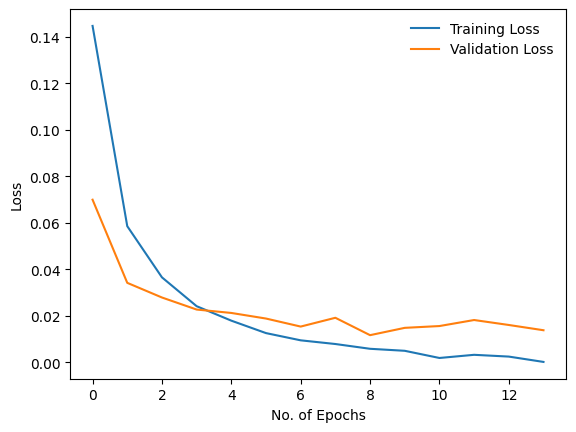

In [21]:
# Plot training / validation loss
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

### Test metrics, introduction to PR Curves

During the previous notebook you plotted the Receiver Operating Characteristic curve. This is not ideal when dealing with imbalanced dataset since the issue of class imbalance can result in a serious bias towards the majority class, reducing the classification performance and increasing the number of **false positives**. Furthermore, in ROC curve calculation, true negatives don't have such meaning any longer.

Instead this time we will plot the Precision Recall curve of our model which uses precision and recall to evaluate models.

![](https://cdn-images-1.medium.com/fit/t/1600/480/1*Ub0nZTXYT8MxLzrz0P7jPA.png)

![](https://modtools.files.wordpress.com/2020/01/roc_pr-1.png?w=946)

Refer here for a tutorial on how to plot such curve:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

More details on PR Curve:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/

**e. Plot the ROC curve of your model as well as its PR Curve, on the test set, compare them, which is easier to interpret ?**

In [32]:
from sklearn.metrics import auc, roc_curve
import tqdm

test_ds = NpArrayDataset(
    images=test_images,
    labels=test_labels,
    image_transforms=image_transforms,
    label_transforms=target_transforms,
)

# Plot ROC curve as in the preview notebook
y_true = []
y_pred = []

# Send model to correct device
model.to(DEVICE)

# Put model in evaluatio mode (very important)
model.eval()

# Disable all gradients things
with torch.no_grad():
    for x, y_t in tqdm.tqdm(test_ds, "predicting"):
        x = x.reshape((-1,) + x.shape)
        x = x.to(DEVICE)
        y = model.forward(x)
        y = y.to("cpu").numpy()

        y_t = int(y_t.to("cpu").numpy())

        y_pred.append(y)
        y_true.append(y_t)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.asarray(y_true)


y_pred_probas = np.round(y_pred[:, 0], 2)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probas)
roc_auc = auc(fpr, tpr)

predicting: 100%|████████████████████████| 10240/10240 [00:15<00:00, 655.43it/s]


In [33]:
# Plot PR curve

# Compute PR Curve

import numpy as np
from sklearn.metrics import (
    PrecisionRecallDisplay,
    average_precision_score,
    precision_recall_curve,
)

# We round predictions for better readability
y_pred_probas = np.round(y_pred[:, 0], 2)

precisions, recalls, thresholds = precision_recall_curve(
    y_true, y_pred_probas, pos_label=1
)

ap = average_precision_score(y_true, y_pred)

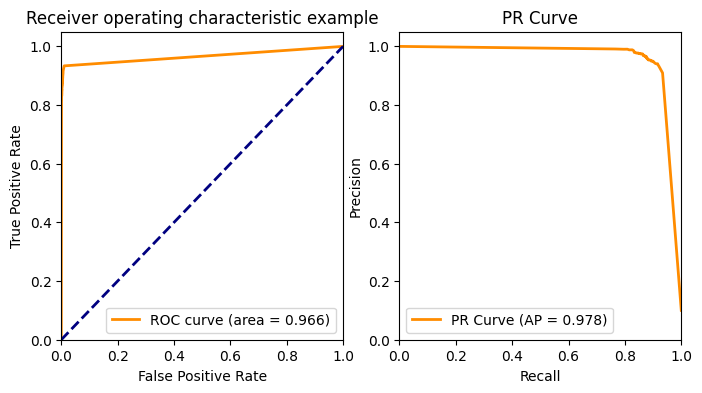

In [38]:
plt.figure(figsize=(8,4))
lw = 2

plt.subplot(1,2,1)
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.3f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(
    recalls, precisions, color="darkorange", lw=lw, label="PR Curve (AP = %0.3f)" % ap
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.legend(loc="lower left")
plt.show()

**f. Can you understand why PR curve may be more useful than ROC curve for diagnosing model performance when dealing with imbalanced data ?**

In [ ]:
# Answer

**g. What is Fbeta-Score ? How can it help ? How do you chose beta?**

Some reading: https://towardsdatascience.com/on-roc-and-precision-recall-curves-c23e9b63820c

In [39]:
def fbeta(precision, recall, beta=1.0):
    if p == 0.0 or r == 0.0:
        return 0.0
    else:
        return (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

**h. Can you use the PR curve to choose a threshold ?**

The same way you did for the ROC curve

/tmp/ipykernel_3788/3637882629.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_probas = (y_pred[:, 0] / 0.05).astype(np.int) * 0.05


<Figure size 640x480 with 0 Axes>

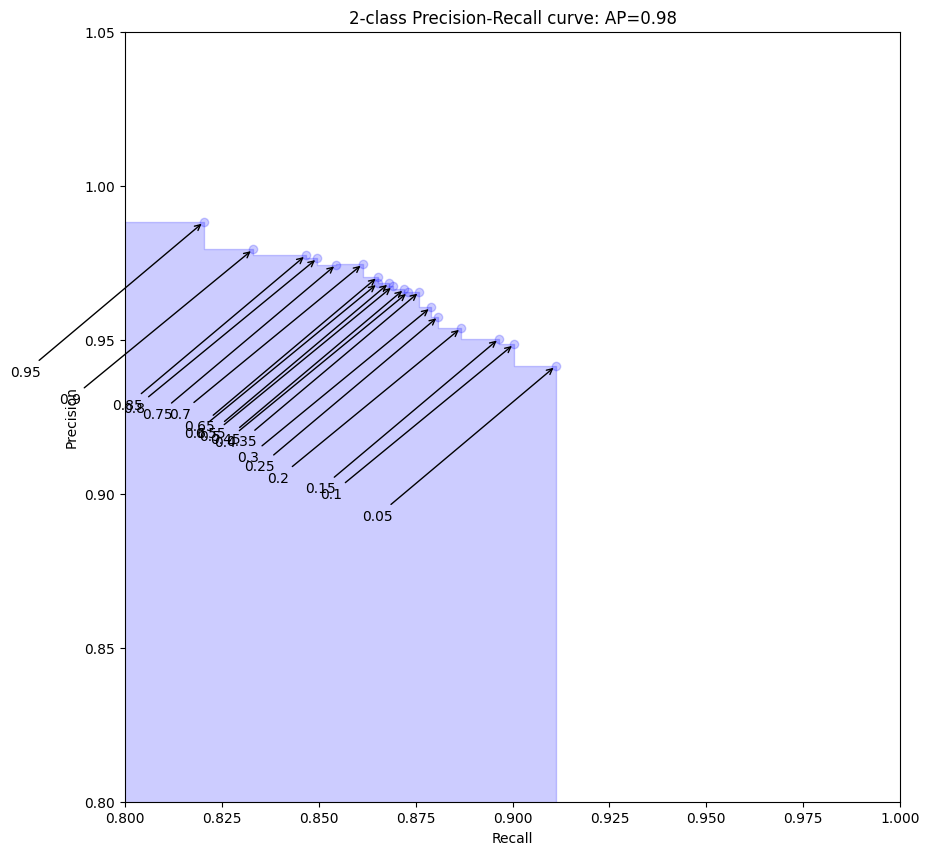

In [41]:
# We round predictions every 0.05 for readability
y_pred_probas = (y_pred[:, 0] / 0.05).astype(np.int) * 0.05

precisions, recalls, thresholds = precision_recall_curve(
    y_true, y_pred_probas, pos_label=1
)

ap = average_precision_score(y_true, y_pred)

plt.clf()
fig = plt.figure(figsize=(10, 10))
plt.step(recalls, precisions, "bo", alpha=0.2, where="post")
plt.fill_between(recalls, precisions, alpha=0.2, color="b", step="post")

for r, p, t in zip(recalls, precisions, thresholds):
    plt.annotate(
        np.round(t, 2),
        xy=(r, p),
        xytext=(r - 0.05, p - 0.05),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.8, 1.05])
plt.xlim([0.8, 1.0])
plt.title("2-class Precision-Recall curve: AP={:0.2f}".format(ap))
plt.show()

You can also use the fbeta score to find the best threshold, for example to maximise f1 or f2...

```python
def find_best_threshold(precisions, recalls, thresholds, beta=2.):
    best_fb = -np.inf
    best_t = None
    for t, p, r in zip(thresholds, precisions, recalls):
        fb = fbeta(p, r, beta=beta)
        if fb > best_fb:
            best_t = t
            best_fb = fb

    return best_fb, best_t
```

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def find_best_threshold(precisions, recalls, thresholds, beta=2.):
    best_fb = -np.inf
    best_t = None
    for t, p, r in zip(thresholds, precisions, recalls):
        fb = fbeta(p, r, beta=beta)
        if fb > best_fb:
            best_t = t
            best_fb = fb

    return best_fb, best_t

0.9170434440731275 0.05
Confusion matrix


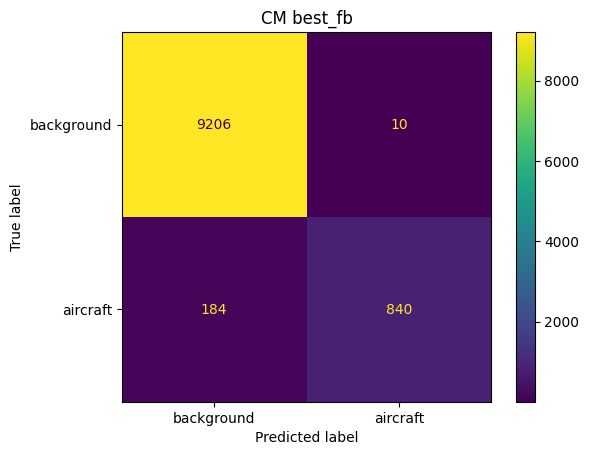

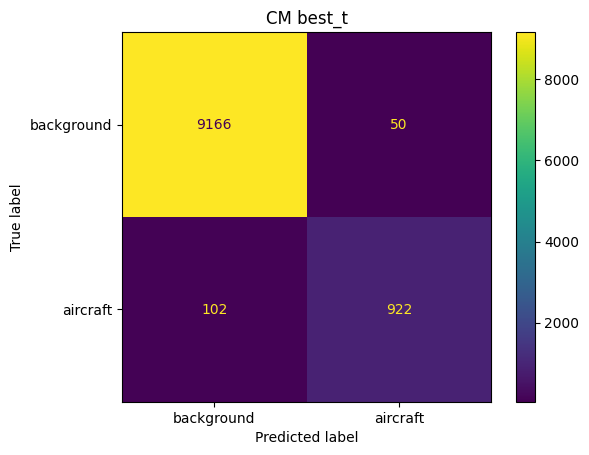

In [53]:
best_fb, best_t = find_best_threshold(precisions, recalls, thresholds, beta=2.)
print(best_fb, best_t)

selected_threshold = best_fb

print("Confusion matrix")

y_pred_classes = y_pred_probas > best_fb

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["background", "aircraft"]
)
disp.plot()
plt.title("CM best_fb")

y_pred_classes = y_pred_probas > best_t

cm = confusion_matrix(y_true, y_pred_classes)


disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["background", "aircraft"]
)
disp.plot()
plt.title("CM best_t")

plt.show()

### Plot "hard" examples

- Plot some of the missclassified examples that have true label = 0: Those are false positives
- Plot some of the missclassified examples that have true label = 1: those are false negatives (misses)

Can you interpret the false positives ?

Example for False Positives 

```python
misclassified_idxs = np.where(y_pred_classes == 1 && y_true == 0)[0]


print(len(misclassified_idxs))

print(misclassified_idxs)

misclassified_images = test_images[misclassified_idxs]
misclassified_true_labels = test_labels[misclassified_idxs]
misclassified_pred_labels = y_pred_classes[misclassified_idxs]

grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        img = np.copy(misclassified_images[i * grid_size + j])
        pred = np.copy(misclassified_pred_labels[i * grid_size + j])
        color = (0, 255, 0) if pred == 1 else (255, 0, 0)
        tile = cv2.rectangle(img, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = img

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()
```

In [56]:
# Do it here!
misclassified_idxs = np.where(y_pred_classes == 1 && y_true == 0)[0]


print(len(misclassified_idxs))

print(misclassified_idxs)

misclassified_images = test_images[misclassified_idxs]
misclassified_true_labels = test_labels[misclassified_idxs]
misclassified_pred_labels = y_pred_classes[misclassified_idxs]

grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        img = np.copy(misclassified_images[i * grid_size + j])
        pred = np.copy(misclassified_pred_labels[i * grid_size + j])
        color = (0, 255, 0) if pred == 1 else (255, 0, 0)
        tile = cv2.rectangle(img, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = img

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Q2. Class Imbalance

We will try several things below. Those steps are only indicative and you are free to pursue other means of improving your model.

Should you be lost, we refer you to the excellent "A Recipe for Training Neural Networks" article : https://karpathy.github.io/2019/04/25/recipe/

![image.png](docs/static/img/mlsystem.png)

### a. Tackling the imbalanced data problem

Go through your data: is the dataset balanced ? If now, which steps can I do to solve this imbalance problem ?

- Which step would you take ?
- **Don't forget to apply the same step on you train and validation dataset** but **not on your test set** as your test set should represent the final data distribution

Try to decide and a method to modify only the dataset and rerun your training. Did performance improve ?


HINT:
- It's usually a mix of **oversampling** the minority class and **undersampling** the majority class

Some readings:
- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets (very well done)
- https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/ (a bigger synthesis)
- https://machinelearningmastery.com/category/imbalanced-classification/

Hint to get you started
```python
background_indexes = np.where(trainval_labels == 0)
foreground_indexes = np.where(trainval_labels == 1)

# Maybe select the same number of background and foreground classes to put into your training / validation set ?
```

In [ ]:
# Q2.a here

### b. Hard Example Mining

Another solution is called "hard example mining" : You could balance your dataset like before, but this time do it "intelligently", for example by selecting false positives and false negatives. Those are "hard examples",

Usually we also put "easy examples" otherwise our dataset may be very biased

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTA35C_SgBtMsS1bt_VR7HC2vDaK8zIlIyw9w&usqp=CAU" alt="drawing" width="400"/>

You can see this effect easily on a confusion matrix :

<img src="https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png" alt="drawing" width="400"/>

If you want to rebalance your dataset by undersampling the 0 class, why not selecting more false positives than true negatives ?

**Try it !**

## Q3. **Optional** Exercises to run at home to improve your training

### a. Optimizer and other hyperparameters modifications

i ) Now that you have worked on your dataset and decided to undersample it, it's time to tune your network and your training configuration

In Session 1, you tested two different optimizers. What is the effect of its modification? Apply it to your training and compare metrics.

ii ) An other important parameter is the learning rate, you can [check its effect on the behavior of your training](https://developers.google.com/machine-learning/crash-course/fitter/graph).

### b. Going Further with hyperparameters tuning

Here is an overview of [possible hyperparameter tuning when training Convolutional Neural Networks](https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8)

You can try and apply those techniques to your use case.

- Does these techniques yield good results ? What about the effort-spent-for-performance ratio ?
- Do you find it easy to keep track of your experiments ?
- What would you need to have a better overview of the effects of these search ?

Don't spend too much time on this part as the next is more important. You can come back to it after you're finished

In [ ]:
# Q2.c here

### c. Model architecture modification

There are no absolute law concerning the structure of your deep Learning model. During the [Deep Learning class](%matplotlib inline) you had an overview of existing models

You can operate a modification on your structure and observe the effect on final metrics. Of course, remain consistent with credible models, cf Layer Patterns chapter on this "must view" course : http://cs231n.github.io/convolutional-networks/

<img src="https://github.com/fchouteau/isae-practical-deep-learning/blob/master/docs/static/img/comparison_architectures.png?raw=true" alt="pokemon" style="width: 400px;"/>


You can also use off the shelf architecture provided by torchvision, for example:

```python
import torchvision.models

resnet18 = torchvision.models.resnet18(num_classes=2)
```

You can also use [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/) to "finetune" already trained features on your dataset

[Please refer to this example on transfer learning](https://nbviewer.jupyter.org/github/pytorch/ignite/blob/master/examples/notebooks/EfficientNet_Cifar100_finetuning.ipynb)

### d. Full Test whole dataset

a. Now that you have optimised your structure for your dataset, you will apply your model to the test dataset to see the final metrics. Plot all your metrics using the full imbalanced test set. Is it good enough ?
If you think so, you can apply it to new images using the sliding window technique with the 3rd notebook

- Did it bring any improvements ?

In [ ]:
# Q3a

### e. Training on hard examples

If you're not satisfied with the output of your model, consider the following idea: Training a new model with the failures of your previous model.
Try the following:
- Get all the images with the "aircraft" label
- Get all the images with the "background" label where your best model was wrong (predicted aircraft), as well as some of the background where it was right.
- Train a new model or retrain your existing one on this dataset.


In [ ]:
# Q3b

### f. **SAVE YOUR MODEL**

In [ ]:
# Q3c

**Have you saved your model ??** You will need it for the next notebook